# Forecasting Movies Revenue Using Machine Learning

## 1 Import Python Libraries

In [1]:
%matplotlib inline
from imports import *

In [2]:
!pip install -U -q easymoney
!pip install -U -q PyDrive
!pip install -U -q DateTime
!pip install -U -q catboost
!pip install -U -q xgboost==0.80
!pip install -U -q lightgbm

In [3]:
from easymoney.money import EasyPeasy
import datetime
from catboost import CatBoostRegressor
import xgboost
import lightgbm

## 2 Data Collection & Integration

### 2.1 Data Combine from Git

We combine the credits.csv and ratings.csv, as they are too large to be stored in GitHub as a single file.

In [4]:
data_combine_from_git.combine('credits',4)
data_combine_from_git.combine('ratings',15)

### 2.2 Data Import

Load the databases from the csv files.

In [5]:
df_ratings = pd.read_csv('ratings.csv')
df_ratings.name = 'Ratings'

df_movies_metadata = pd.read_csv('movies_metadata.csv')
df_movies_metadata = df_movies_metadata[df_movies_metadata.budget.apply(lambda x: x.isnumeric())]
df_movies_metadata[["budget", "revenue"]] = df_movies_metadata[["budget", "revenue"]].apply(pd.to_numeric)
df_movies_metadata.name = 'Movies Metadata'

df_credits = pd.read_csv('credits.csv')
df_credits.name = 'Credits'

df_ages=pd.read_csv('age_scrape.csv')
df_ages.name='Ages'

### 2.3 Scraped Data Integration

Load the combined_new_db.csv which we scraped from IMDb.

In [6]:
df_scraped_new_movies=pd.read_csv('combined_new_db.csv',encoding='latin-1')
          
df_scraped_new_movies['original_title'] = df_scraped_new_movies['original_title'].map(scraped_data_integration.get_title)
money=['budget','revenue']
df_scraped_new_movies[money]=df_scraped_new_movies[money].applymap(scraped_data_integration.get_money_new_movies)
df_scraped_new_movies['release_month'] = df_scraped_new_movies['release_month'].map(scraped_data_integration.get_month)
need_to_be_extracted=['genres', 'production_companies', 'director','cast']
df_scraped_new_movies[need_to_be_extracted] = df_scraped_new_movies[need_to_be_extracted].applymap(scraped_data_integration.get_values)

print("Additional data scraped, example rows:")
display(df_scraped_new_movies.head(2))

Additional data scraped, example rows:


,imdb_id,vote_average,age,original_title,release_year,original_language,runtime,revenue,budget,release_day,release_month,genres,production_companies,cast,director
0,tt2888046,7.1,teen,Yip Man 3,2015,zh,105,1.568448e+08,36000000.0,24,12.0,"[Action, Biography, Drama, History]","[Dreams Salon Entertainment Culture, Henan Fil...","[Donnie Yen, Lynn Xiong, Jin Zhang, Mike Tyson...",[Wilson Yip]
1,tt1825683,7.4,teen,Black Panther,2018,en,134,1.347071e+09,200000000.0,15,2.0,"[Action, Adventure, Sci-Fi]","[Marvel Studios, Moonlighting Films, Korean Fi...","[Chadwick Boseman, Michael B. Jordan, Lupita N...",[Ryan Coogler]


##  3 Data Preparation and Cleaning

### 3.1 Data Preparation

#### 3.1.1 Drop Unnecessary Columns

In [7]:
col_of_interest_movies_metadata=['id', 'original_title','release_date','original_language','spoken_languages',
                                 'runtime','genres','adult','production_companies','production_countries','budget',
                                 'revenue', 'vote_average','imdb_id']
df_movies_metadata=df_movies_metadata[col_of_interest_movies_metadata]

col_of_interest_credits=['id','cast','crew']
df_credits=df_credits[col_of_interest_credits]

# Change name to id column
df_ratings["id"] = df_ratings["movieId"]
df_ratings = df_ratings.drop(['movieId'],axis=1)
col_of_intrest_ratings = ['id', 'rating']
df_ratings = df_ratings[col_of_intrest_ratings]


#### 3.1.2 Type Conversion

##### 3.1.2.1 Convert Categorical and Binary Variables to String

In [8]:
df_movies_metadata['id'] = df_movies_metadata['id'].astype(np.str)

df_credits_categorical_variables=['id','cast','crew']
for variable in  df_credits_categorical_variables:
    df_credits[variable] = df_credits[variable].astype(np.str)
    
df_ratings['id'] = df_ratings['id'].astype(np.str)

##### 3.1.2.2 Convert Numeric Variables to Float

In [9]:
df_movies_metadata_numeric_variables = ['runtime','budget','revenue', 'vote_average']
df_movies_metadata[df_movies_metadata_numeric_variables]= df_movies_metadata[df_movies_metadata_numeric_variables].astype(np.float)

#### 3.1.3 Integrate Age Data

The age data represents the target age group (kids / teen / adult / na). This data is in another table, which we scraped.

In [10]:
df_movies_metadata =pd.merge(df_movies_metadata,df_ages,on='imdb_id',how='outer')

#### 3.1.4 Joining The Two Dataframes

##### 3.1.4.1 Checking duplicates

In [11]:
print("Total df_movies_metadata rows: {}, unique rows: {}".format(df_movies_metadata.shape[0],df_movies_metadata.id.nunique()))
print("Total df_credits rows: {}, unique rows: {}".format(df_credits.shape[0],df_credits.id.nunique()))
print("Total df_ratings rows: {}, unique rows: {}".format(df_ratings.shape[0],df_ratings.id.nunique()))
print("")
print("Example of df_movies_metadata duplicate rows:")
display(pd.concat(g for _, g in df_movies_metadata.groupby("id") if len(g) > 1).head(4))

Total df_movies_metadata rows: 45463, unique rows: 45433
Total df_credits rows: 45476, unique rows: 45432
Total df_ratings rows: 26024289, unique rows: 45115

Example of df_movies_metadata duplicate rows:


,id,original_title,release_date,original_language,spoken_languages,runtime,genres,adult,production_companies,production_countries,budget,revenue,vote_average,imdb_id,age
676,105045,Das Versprechen,1995-02-16,de,"[{'iso_639_1': 'de', 'name': 'Deutsch'}]",115.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",False,"[{'name': 'Studio Babelsberg', 'id': 264}, {'n...","[{'iso_3166_1': 'DE', 'name': 'Germany'}]",0.0,0.0,5.0,tt0111613,NaN
677,105045,Das Versprechen,1995-02-16,de,"[{'iso_639_1': 'de', 'name': 'Deutsch'}]",115.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",False,"[{'name': 'Studio Babelsberg', 'id': 264}, {'n...","[{'iso_3166_1': 'DE', 'name': 'Germany'}]",0.0,0.0,5.0,tt0111613,NaN
4117,10991,Pokémon 3: The Movie,2000-07-08,ja,"[{'iso_639_1': 'en', 'name': 'English'}]",93.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",False,"[{'name': 'TV Tokyo', 'id': 3034}, {'name': '4...","[{'iso_3166_1': 'JP', 'name': 'Japan'}]",16000000.0,68411275.0,6.0,tt0235679,kid
4118,10991,Pokémon 3: The Movie,2000-07-08,ja,"[{'iso_639_1': 'en', 'name': 'English'}]",93.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",False,"[{'name': 'TV Tokyo', 'id': 3034}, {'name': '4...","[{'iso_3166_1': 'JP', 'name': 'Japan'}]",16000000.0,68411275.0,6.0,tt0235679,kid


##### 3.1.4.2 Drop duplicates

In [12]:
# It seems like all the duplicates are the same and don't really contain any new information. We will keep one copy.
df_movies_metadata=df_movies_metadata.drop_duplicates(subset=['id'])
df_credits=df_credits.drop_duplicates(subset=['id'])

##### 3.1.4.3 Keep only average rating per movie

For each movie we have many user ratings, we keep only the average.

In [13]:
df_ratings = pd.DataFrame({'avg_rating' : df_ratings.groupby('id')['rating'].sum() / df_ratings.groupby('id')['rating'].count()}).reset_index()

##### 3.1.4.4 Combine the movie metadata, credits and ratings tables

In [14]:
df =pd.merge(df_movies_metadata,df_credits, on='id',how='inner')
df =pd.merge(df, df_ratings, on='id',how='left')

#### 3.1.5 Extracting useful information

##### 3.1.5.1 Extract the release date information

Format the release date from DD/MM/YYYY format to three seperate columns.

In [15]:
df['release_year']=pd.to_datetime(df['release_date']).apply(lambda x: x.year)
df['release_month']=pd.to_datetime(df['release_date']).apply(lambda x: x.month)
df['release_day']=pd.to_datetime(df['release_date']).apply(lambda x: extracting_useful_information.get_day(x))

df=df.drop(['release_date'],axis=1)
print("Database after splitting the date from DD/MM/YYYY format to three seperate columns:")
display(df.head(1))

Database after splitting the date from DD/MM/YYYY format to three seperate columns:


,id,original_title,original_language,spoken_languages,runtime,genres,adult,production_companies,production_countries,budget,revenue,vote_average,imdb_id,age,cast,crew,avg_rating,release_year,release_month,release_day
0,862,Toy Story,en,"[{'iso_639_1': 'en', 'name': 'English'}]",81.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",False,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",30000000.0,373554033.0,7.7,tt0114709,kid,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",3.59893,1995.0,10.0,Mon


##### 3.1.5.2 Extract the values from the categorical columns

In the database we have lists stored in a string format. For example the genres of the movies are stored in a string, with the genres seperated by a comma.<br>
We turn these strings into a python list.

In [16]:
# Turns a string that represents a list into a python list
need_to_be_extracted=['genres', 'production_companies', 'production_countries', 'spoken_languages','cast']
df[need_to_be_extracted] = df[need_to_be_extracted].applymap(extracting_useful_information.get_values)

# Extracing the director from crew array
df['director'] = df['crew'].map(extracting_useful_information.get_director)

#### 3.1.6 Scraped Data Integration

We combine the scraped movie database with the original Kaggle database.

In [17]:
df_scraped_new_movies['release_day']=df_scraped_new_movies['release_day'].apply(extracting_useful_information.get_day)
df = pd.concat([df,df_scraped_new_movies]).reset_index(drop=True)
df = df.drop_duplicates(subset='imdb_id', keep="last")

#### 3.1.7 Selecting the relevant columns from the full DB

In [18]:
col_of_interest_df=['id', 'original_title','release_year','release_month','release_day',
                    'original_language','spoken_languages','runtime','genres','age',
                    'adult','production_companies','production_countries','cast','director','budget','revenue', 'vote_average', 'avg_rating']
df=df[col_of_interest_df]
print("Example of a movie with all the extracted relevant columns")
display(df.head(1))

Example of a movie with all the extracted relevant columns


,id,original_title,release_year,release_month,release_day,original_language,spoken_languages,runtime,genres,age,adult,production_companies,production_countries,cast,director,budget,revenue,vote_average,avg_rating
2,15602,Grumpier Old Men,1995.0,12.0,Fri,en,[English],101.0,"[Romance, Comedy]",NaN,False,"[Warner Bros., Lancaster Gate]",[United States of America],"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...",[Howard Deutch],0.0,0.0,6.5,NaN


### 3.2 Data Cleaning

#### 3.2.1 Impute Missing Values

In [19]:
print("For each column, count the number of missing values:")
df.isnull().sum()

For each column, count the number of missing values:


id                       2779
original_title              0
release_year               85
release_month              87
release_day              2864
original_language          11
spoken_languages         6601
runtime                   258
genres                   2437
age                     39684
adult                    2779
production_companies    11838
production_countries     9045
cast                     2411
director                  768
budget                      0
revenue                     3
vote_average                3
avg_rating              38837
dtype: int64

#### 3.2.2 Replacing and removing missing values

In [20]:
# release_year
print("Replacing each missing value in release_year with release_year mode (={})".format(df["release_year"].mode()[0]))
df["release_year"].fillna(df["release_year"].mode()[0], inplace=True)

# release month
print("Replacing each missing value in release_month with release_month mode (={})".format(df["release_month"].mode()[0]))
df["release_month"].fillna(df["release_month"].mode()[0], inplace=True)

# release day
print("Replacing each missing value in release_day with release_day mode (={})".format(df["release_day"].mode()[0]))
df["release_day"].fillna(df["release_day"].mode()[0], inplace=True)

# original language
print("Replacing each missing value in original_language with original_language mode (={})".format(df["original_language"].mode()[0]))
df["original_language"].fillna(df["original_language"].mode()[0], inplace=True)

# age
print("Replacing each missing value in age with na")
df["age"].fillna('na', inplace=True)

# runtime
print("Replacing each 0/Nan in runtime with runtime mean (={})".format(df["runtime"].mean()))
df["runtime"].replace(0, df["runtime"][df["runtime"] != 0].mean(), inplace=True)
df["runtime"].fillna(df["runtime"][df["runtime"] != 0].mean(), inplace=True)

# avg_rating
print("Replacing each na in avg_rating with -1 so we'll know it's missing")
df["avg_rating"].fillna(-1, inplace=True)

# vote_average
print("Replacing each na in vote_average with -1 so we'll know it's missing")
df["vote_average"].fillna(-1, inplace=True)

# revenue
df.drop(df[df.revenue == 0].index, inplace=True)

# budget - We estimate the budget later
df.drop(df[df.budget == 0].index, inplace=True)

Replacing each missing value in release_year with release_year mode (=2014.0)
Replacing each missing value in release_month with release_month mode (=1.0)
Replacing each missing value in release_day with release_day mode (=Fri)
Replacing each missing value in original_language with original_language mode (=en)
Replacing each missing value in age with na
Replacing each 0/Nan in runtime with runtime mean (=94.19610960234925)
Replacing each na in avg_rating with -1 so we'll know it's missing
Replacing each na in vote_average with -1 so we'll know it's missing


#### 3.2.3 Drop all rows with missing data

Drop all rows with missing data, after we filled missing values in the previous block.<br>Ignore missing values in the following columns - adult, production_countries, id, spoken_languages.

In [21]:
na_free = df.dropna(subset=[item for item in list(df.columns.values) if item not in ['adult','production_countries','id','spoken_languages']])
only_na = df[~df.index.isin(na_free.index)]
df = na_free
print("Displaying example dropped rows:")
display(only_na.head(5))

Displaying example dropped rows:


,id,original_title,release_year,release_month,release_day,original_language,spoken_languages,runtime,genres,age,adult,production_companies,production_countries,cast,director,budget,revenue,vote_average,avg_rating
386,22067,Jason's Lyric,1994.0,9.0,Wed,en,[English],119.0,"[Crime, Drama, Romance]",na,False,None,[United States of America],"[Allen Payne, Jada Pinkett Smith, Bokeem Woodb...",[Doug McHenry],7000000.0,20851521.0,5.9,-1.000000
805,11962,Joe's Apartment,1996.0,7.0,Fri,en,[English],78.0,"[Fantasy, Comedy, Music]",teen,False,None,[United States of America],"[Jerry O'Connell, Megan Ward, Billy West, Regi...",[John Payson],13000000.0,4619014.0,5.0,-1.000000
1151,31225,Paris is Burning,1990.0,3.0,Tue,en,[English],71.0,[Documentary],adult,False,None,[United States of America],"[Dorian Corey, Pepper LaBeija, Willi Ninja, Oc...",[Jennie Livingston],500000.0,3779620.0,8.2,3.642808
1486,49235,Squeeze,1997.0,6.0,Fri,en,None,95.0,"[Crime, Drama]",adult,False,None,None,"[Tyrone Burton, Eddie Cutanda, Phuong Duong, G...",[Robert Patton-Spruill],500000.0,10300.0,6.0,-1.000000
1775,9844,The Opposite of Sex,1998.0,5.0,Fri,en,[English],105.0,"[Comedy, Drama]",adult,False,None,[United States of America],"[Christina Ricci, Martin Donovan, Lisa Kudrow,...",[Don Roos],5000000.0,5879254.0,5.9,-1.000000


#### 3.2.4 Inflation Normalization

Normalize the buget and revenue according to inflation, all amounts are normalized to their 2017 equivalent.<br>
The python library which we use only has information until 2017, however the inflation between 2017-2019 is negligible.

In [22]:
df = df.copy()
ep = EasyPeasy()
# USA: Alpha2 = US/ Alpha3 = USA/ Currencies = USD/ InflationDates = [1960,2017]

# We've got inflation history only since 1960
df=df[df.release_year>1959]

out = df.apply(lambda x: ep.normalize(amount=x.budget, region="USA", from_year=x.release_year, to_year="2017", base_currency="USD", pretty_print=False), axis=1)
df['budget_InfAdj'] = out

out = df.apply(lambda x: ep.normalize(amount=x.revenue, region="USA", from_year=x.release_year, to_year="2017", base_currency="USD", pretty_print=False), axis=1)
df['revenue_InfAdj'] = out

print("Example rows after inflation normalization:")
display(df.head(3))

Example rows after inflation normalization:


,id,original_title,release_year,release_month,release_day,original_language,spoken_languages,runtime,genres,age,...,production_companies,production_countries,cast,director,budget,revenue,vote_average,avg_rating,budget_InfAdj,revenue_InfAdj
8,9091,Sudden Death,1995.0,12.0,Fri,en,[English],106.0,"[Action, Adventure, Thriller]",adult,...,"[Universal Pictures, Imperial Entertainment, S...",[United States of America],"[Jean-Claude Van Damme, Powers Boothe, Dorian ...",[Peter Hyams],35000000.0,64350171.0,5.5,-1.000000,5.630002e+07,1.035119e+08
10,9087,The American President,1995.0,11.0,Fri,en,[English],106.0,"[Comedy, Drama, Romance]",teen,...,"[Columbia Pictures, Castle Rock Entertainment]",[United States of America],"[Michael Douglas, Annette Bening, Michael J. F...",[Rob Reiner],62000000.0,107879496.0,6.5,-1.000000,9.973147e+07,1.735320e+08
14,1408,Cutthroat Island,1995.0,12.0,Fri,en,"[English, Latin]",119.0,"[Action, Adventure]",teen,...,"[Le Studio Canal+, Laurence Mark Productions, ...","[France, Germany, Italy, United States of Amer...","[Geena Davis, Matthew Modine, Frank Langella, ...",[Renny Harlin],98000000.0,10017322.0,5.7,3.710181,1.576401e+08,1.611358e+07


#### 3.2.5 Remove Runtime Outliers

Remove all movies whose length is more than 4 hours, they are outliers in thier category.<br>
This effects only a 0.0000036 percentage of the movies.

Outlier runtime movies percentage: 0.0000036%
Histogram of runtimes after outlier removal:


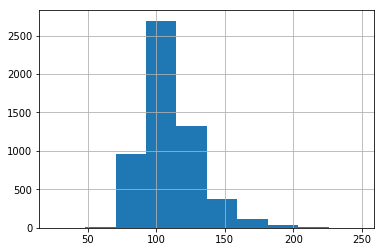

In [23]:
outlier_indices = df[df['runtime'].apply(lambda x: x>250)].index
print("Outlier runtime movies percentage: {0:.7f}%".format(len(outlier_indices)/(len(df)*100.0)))
df.drop(outlier_indices, inplace=True)
print("Histogram of runtimes after outlier removal:")
df['runtime'].hist()

#### 3.2.6 Remove unpopular actors

We don't rank actors, who have less than 10 appearances in films.<br>We remove then from the cast list in all movies they appear.

In [24]:
all_actors = {}
for movie_cast in df['cast']:
  for actor in movie_cast:
    if actor not in all_actors:
      all_actors[actor] = 1
    else:
      all_actors[actor] = all_actors[actor] + 1

popular_actors = []
for actor,num_movies in all_actors.items():
  if num_movies >= 10:
    popular_actors.append(actor)
  
for i, row in df.iterrows():
  movie_cast=row['cast']
  movie_cast=[x for x in movie_cast if x in popular_actors]
  df.set_value(i,'cast',movie_cast)

print("We are left with {} actors that have over 10 movies".format(len(popular_actors)))

We are left with 2551 actors that have over 10 movies


#### 3.2.7 Define relevant years

We are looking at the last 25 years for training / cross validation / test.<br>
Remark - for creating the profiles for studios, actors and directors, we use the entire dataset.

In [25]:
start_year = 1993
end_year = 2020

## 4 Data Visualization and Analysis

### 4.1 Data Visualization

#### 4.1.1 Number of movies per genre

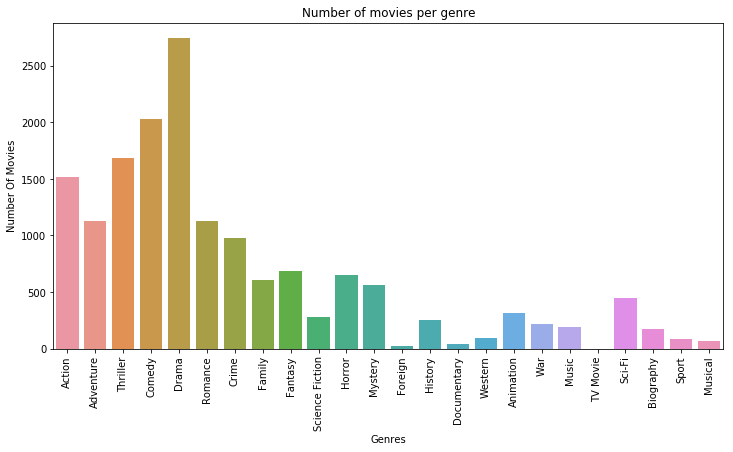

In [26]:
data_visualization_and_analysis.high_order_categorical_countplot(df, 'genres')
data_visualization_and_analysis.set_graph_labels('Number of movies per genre','Genres','Number Of Movies')
plt.xticks(rotation=90)
plt.show()

#### 4.1.2 Boxplot of movies per genre against Inflation Adjusted Revenue

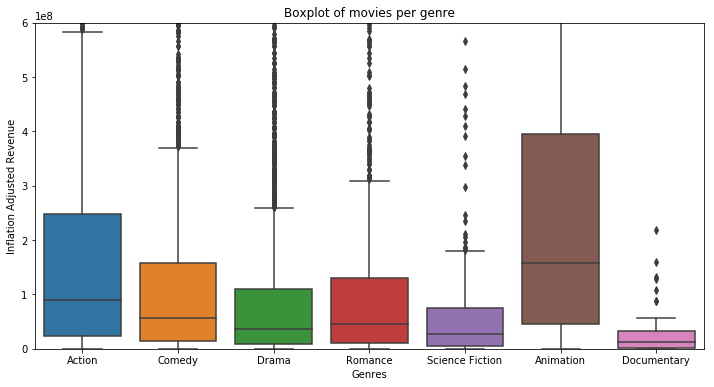

In [27]:
selected_genres = ['Action', 'Comedy','Drama',  'Romance', 'Science Fiction', 'Animation', 'Documentary']
data_visualization_and_analysis.high_order_categorical_boxplot(df, 'genres','revenue_InfAdj',selected_genres)
data_visualization_and_analysis.set_graph_labels('Boxplot of movies per genre','Genres','Inflation Adjusted Revenue')
plt.show()

#### 4.1.3 Top 20 participating actors

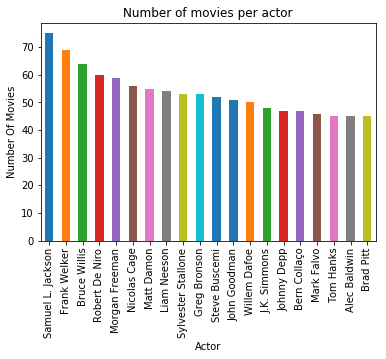

In [28]:
actor_movies_count = pd.Series(data_visualization_and_analysis.counting_values(df, 'cast'))
actor_movies_count.sort_values(ascending = False).head(20).plot(kind = 'bar')
data_visualization_and_analysis.set_graph_labels('Number of movies per actor','Actor','Number Of Movies')
plt.show()

#### 4.1.4 Number of movies per actor for selcted actors

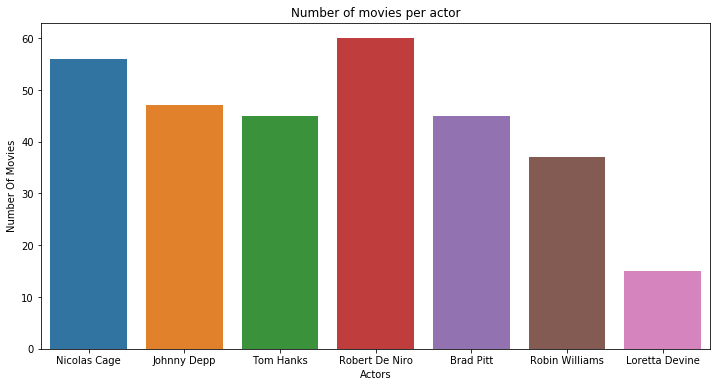

In [29]:
selected_actors = ['Nicolas Cage', 'Johnny Depp','Tom Hanks','Robert De Niro','Brad Pitt','Robin Williams','Loretta Devine']
data_visualization_and_analysis.high_order_categorical_countplot(df, 'cast',selected_actors)
data_visualization_and_analysis.set_graph_labels('Number of movies per actor','Actors','Number Of Movies')
plt.show()

#### 4.1.5 Boxplot of movies per selcted actor against Inflation Adjusted Revenue

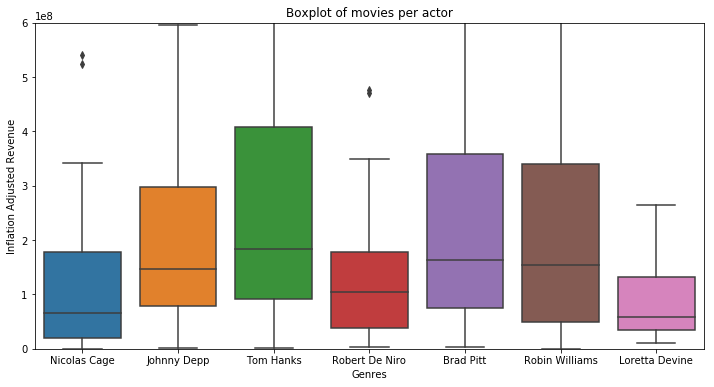

In [30]:
data_visualization_and_analysis.high_order_categorical_boxplot(df, 'cast','revenue_InfAdj',selected_actors)
data_visualization_and_analysis.set_graph_labels('Boxplot of movies per actor','Genres','Inflation Adjusted Revenue')
plt.show()

#### 4.1.6 Number of movies per director for selcted directors


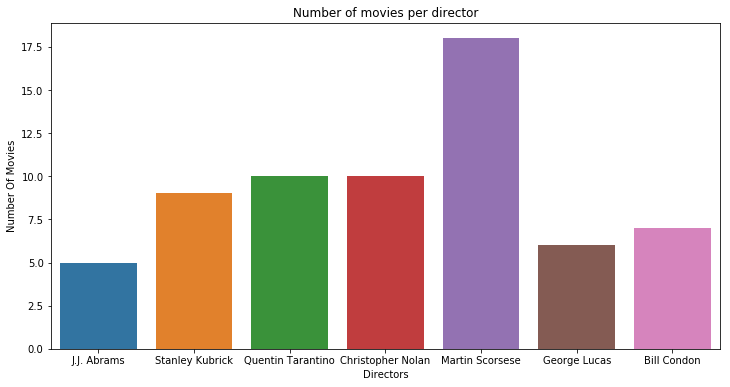

In [31]:
selected_directors = ['J.J. Abrams', 'Stanley Kubrick','Quentin Tarantino','Christopher Nolan',
                     'Martin Scorsese','George Lucas','Bill Condon']
data_visualization_and_analysis.high_order_categorical_countplot(df, 'director',selected_directors)
data_visualization_and_analysis.set_graph_labels('Number of movies per director','Directors','Number Of Movies')
plt.show()

#### 4.1.7 Boxplot of movies per selcted director against Inflation Adjusted Revenue

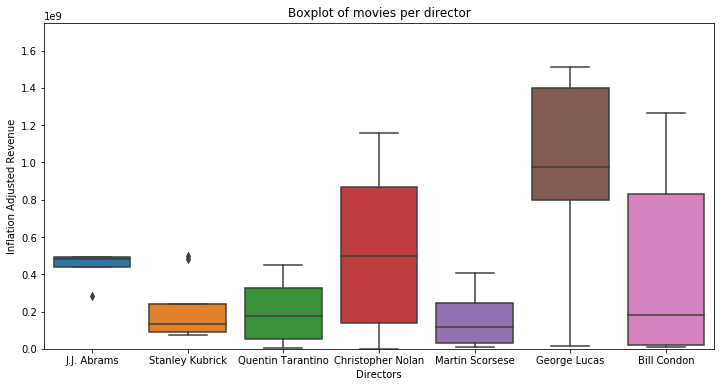

In [32]:
data_visualization_and_analysis.high_order_categorical_boxplot(df, 'director','revenue_InfAdj',selected_directors,1.75e9)
data_visualization_and_analysis.set_graph_labels('Boxplot of movies per director','Directors','Inflation Adjusted Revenue')
plt.show()

#### 4.1.8 Number of movies per studio for selcted studios


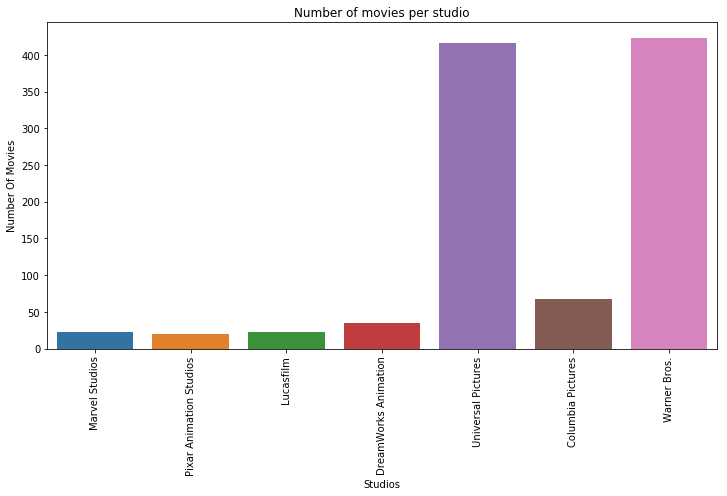

In [33]:
selected_studios = ['Marvel Studios', 'Pixar Animation Studios','Lucasfilm','DreamWorks Animation',
                     'Universal Pictures','Columbia Pictures','Warner Bros.']
data_visualization_and_analysis.high_order_categorical_countplot(df, 'production_companies',selected_studios)
data_visualization_and_analysis.set_graph_labels('Number of movies per studio','Studios','Number Of Movies')
plt.xticks(rotation=90)
plt.show()

#### 4.1.9 Boxplot of movies per selcted studio against Inflation Adjusted Revenue

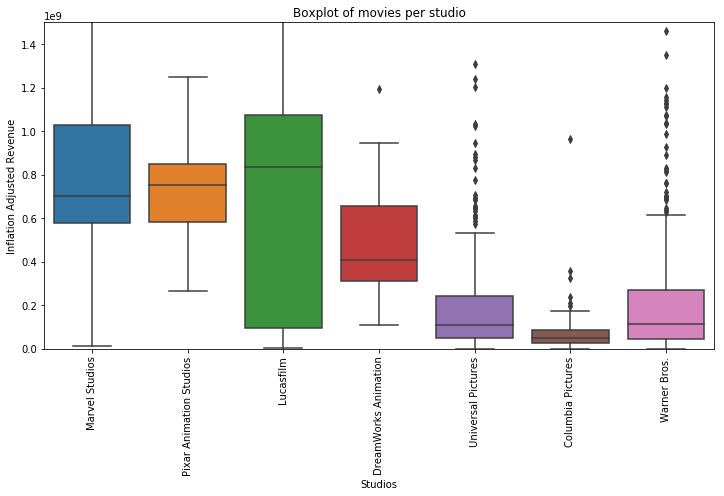

In [34]:
data_visualization_and_analysis.high_order_categorical_boxplot(df, 'production_companies','revenue_InfAdj',selected_studios,1.5e9)
data_visualization_and_analysis.set_graph_labels('Boxplot of movies per studio','Studios','Inflation Adjusted Revenue')
plt.xticks(rotation=90)
plt.show()


#### 4.1.10 Total revenue per year

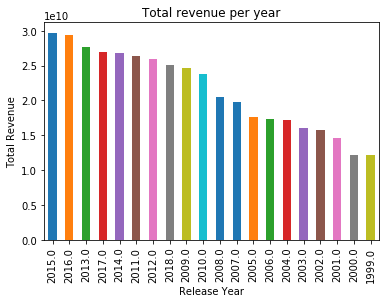

In [35]:
revenue_per_year=df.groupby(["release_year"]).sum().sort_values("revenue",ascending=False).revenue
revenue_per_year.head(20).plot.bar()
data_visualization_and_analysis.set_graph_labels('Total revenue per year','Release Year','Total Revenue')
plt.show()

#### 4.1.11 Revenue over time

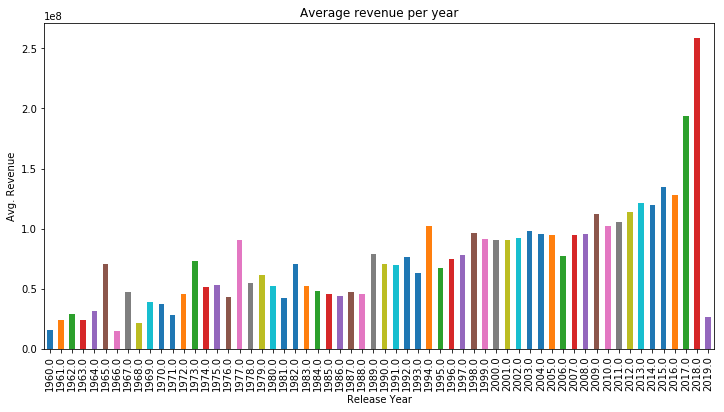

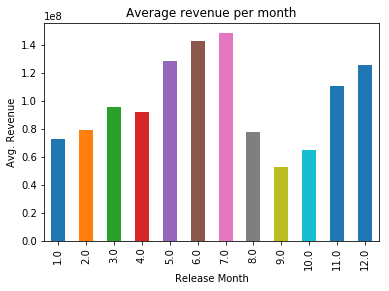

In [36]:
avg_revenue_per_year=df.groupby(["release_year"]).mean().revenue
plt.figure(figsize=(12,6))
avg_revenue_per_year.plot.bar()
data_visualization_and_analysis.set_graph_labels('Average revenue per year','Release Year','Avg. Revenue')
plt.show()

avg_revenue_per_month=df.groupby(["release_month"]).mean().revenue
avg_revenue_per_month.plot.bar()
data_visualization_and_analysis.set_graph_labels('Average revenue per month','Release Month','Avg. Revenue')
plt.show()

#### 4.1.12 Boxplot of inflation adjusted revenue by Year for All Movies

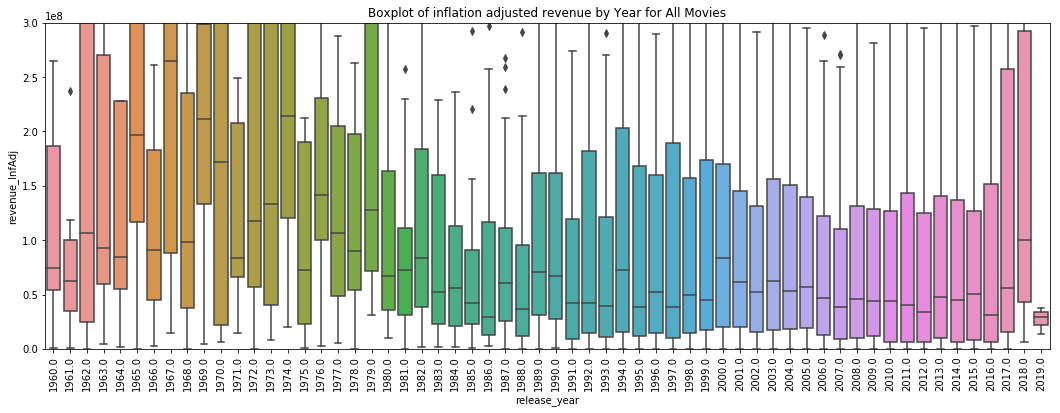

In [37]:
plt.figure(figsize=(18,6))
plt.xticks(rotation=90)
plt.title("Boxplot of inflation adjusted revenue by Year for All Movies")
ax=sns.boxplot(x='release_year', y='revenue_InfAdj', data=df)
ax.set_ylim([0, 3e8]);

#### 4.1.13 Number of Movies released on a particular year

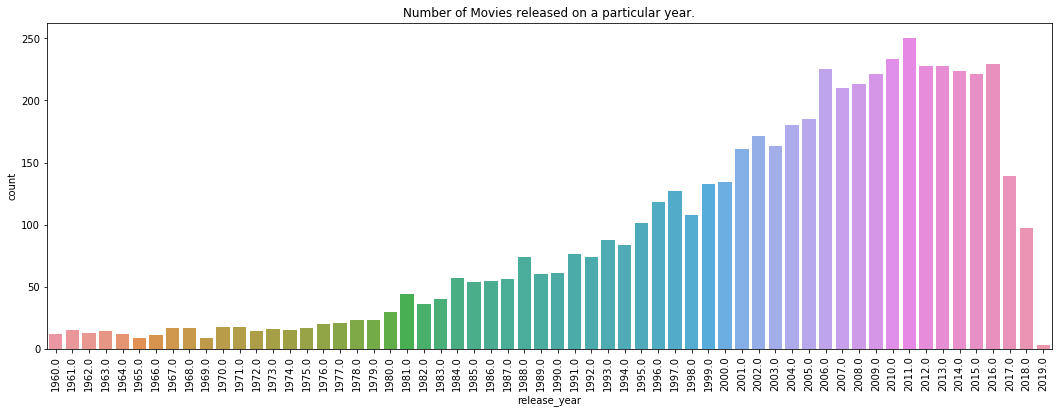

In [38]:
plt.figure(figsize=(18,6))
plt.xticks(rotation=90)
plt.title("Number of Movies released on a particular year.")
sns.countplot(x='release_year', data=df)

#### 4.1.14 Boxplot of revenue by month for all movies

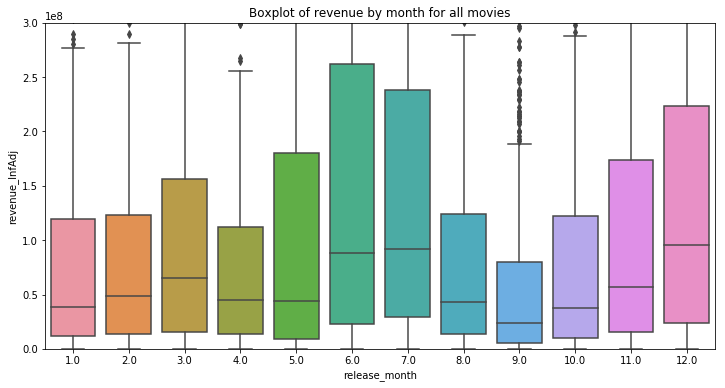

In [39]:
plt.figure(figsize=(12,6))
plt.title("Boxplot of revenue by month for all movies")
ax=sns.boxplot(x='release_month', y='revenue_InfAdj', data=df)
ax.set_ylim([0, 3e8]);

#### 4.1.15 Number of Movies released on a particular month

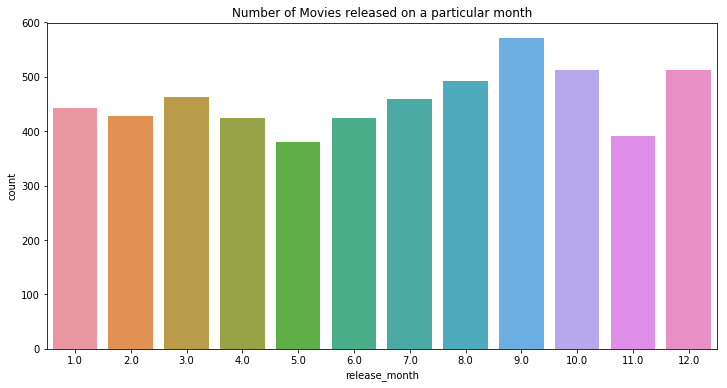

In [40]:
plt.figure(figsize=(12,6))
plt.title("Number of Movies released on a particular month")
sns.countplot(x='release_month', data=df)

#### 4.1.16 Boxplot of revenue by day for all movies

(0, 300000000.0)

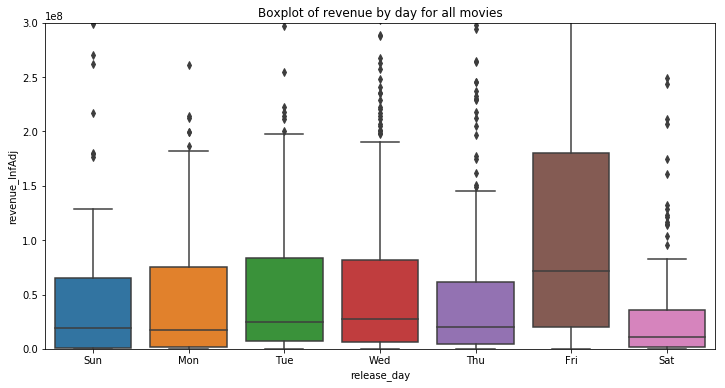

In [41]:
day_order = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
plt.figure(figsize=(12,6))
plt.title("Boxplot of revenue by day for all movies")
ax=sns.boxplot(x='release_day',y='revenue_InfAdj', data=df ,order=day_order)
ax.set_ylim([0, 3e8])

#### 4.1.17 Number of movies released on a particular day

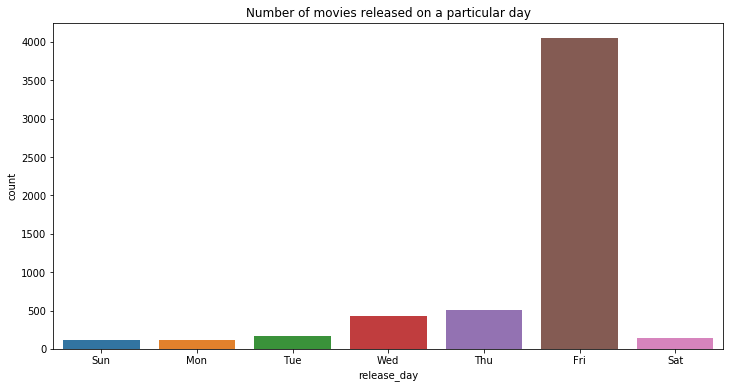

In [42]:
plt.figure(figsize=(12,6))
plt.title("Number of movies released on a particular day")
sns.countplot(x='release_day', data=df, order=day_order)

### 4.2 Data Statistics

We calculate studios, actors, and directors statistics. We will use these statistics later to perform profiling.<br>
Therefore, these statistics are calculated for each year - such that according to our definition the statistics only include data acquired until the release year, <b>not including the actual release year and later</b>.

#### 4.2.1 Statistics overview

In [43]:
print("Revenue skewness: {}".format(df["revenue"].skew()))
print("Revenue kurtosis: {}".format(df["revenue"].kurt()))
print("")
print("Statistics overview about the dataset:")
display(df.describe())

Revenue skewness: 4.931854710809745
Revenue kurtosis: 40.97682616880962

Statistics overview about the dataset:


,release_year,release_month,runtime,budget,revenue,vote_average,avg_rating,budget_InfAdj,revenue_InfAdj
count,5505.000000,5505.000000,5505.000000,5.505000e+03,5.505000e+03,5505.000000,5505.000000,5.505000e+03,5.505000e+03
mean,2002.312625,6.670481,109.830012,3.315671e+07,9.719777e+07,6.358601,-0.466367,4.365663e+07,1.335440e+08
std,12.124213,3.454497,20.243916,4.059528e+07,1.780542e+08,0.976485,1.411116,4.836286e+07,2.304251e+08
min,1960.000000,1.000000,26.000000,1.000000e+00,1.000000e+00,0.000000,-1.000000,1.030000e+00,1.030000e+00
25%,1996.000000,4.000000,96.000000,7.000000e+06,9.448082e+06,5.800000,-1.000000,1.067622e+07,1.317060e+07
50%,2005.000000,7.000000,106.000000,1.900000e+07,3.458627e+07,6.400000,-1.000000,2.725444e+07,5.187032e+07
75%,2011.000000,10.000000,120.000000,4.000000e+07,1.060313e+08,7.000000,-1.000000,5.898915e+07,1.539323e+08
max,2019.000000,12.000000,248.000000,3.210000e+08,2.905059e+09,9.300000,4.500000,6.482501e+08,3.288303e+09


#### 4.2.2 Studios statistics

For each studio we calculate - total revenue, average revenue, and number of movies.

In [44]:
com_pivot_per_year = {}

for i in range(start_year,end_year):
  df_copy = df[df.release_year<i].copy()
  s = df_copy.apply(lambda x: pd.Series(x['production_companies']),axis=1).stack().reset_index(level=1, drop=True)
  s.name = 'companies'

  com_df = df_copy.drop('production_companies', axis=1).join(s)

  com_sum = pd.DataFrame(com_df.groupby('companies')['revenue_InfAdj'].sum().sort_values(ascending=False))
  com_sum.columns = ['Total']
  com_mean = pd.DataFrame(com_df.groupby('companies')['revenue_InfAdj'].mean().sort_values(ascending=False))
  com_mean.columns = ['Average']
  com_count = pd.DataFrame(com_df.groupby('companies')['revenue_InfAdj'].count().sort_values(ascending=False))
  com_count.columns = ['Number']

  com_pivot = pd.concat((com_sum, com_mean, com_count), axis=1)
  com_pivot_per_year[i] = com_pivot
  
print("Top earning studios:")
display(com_pivot.sort_values('Total', ascending=False).head(10))

Top earning studios:


,Total,Average,Number
Warner Bros.,9.099282e+10,2.151130e+08,423
Universal Pictures,8.472591e+10,2.036681e+08,416
Paramount Pictures,7.389377e+10,2.212388e+08,334
Walt Disney Pictures,7.077025e+10,4.138611e+08,171
Columbia Pictures Corporation,5.473674e+10,2.050065e+08,267
Twentieth Century Fox,5.068342e+10,2.929677e+08,173
New Line Cinema,3.028428e+10,1.593909e+08,190
Amblin Entertainment,2.874329e+10,4.422045e+08,65
DreamWorks,2.497060e+10,2.448098e+08,102
United Artists,2.412376e+10,2.461608e+08,98


#### 4.2.3 Directors statistics

For each director we calculate - total revenue, average revenue, number of movies, imdb vote average, imdb average rating, number of votes, number of ratings.

In [45]:
dir_pivot_con_per_year = {}

for i in range(start_year,end_year):
  df_copy2 = df[df.release_year<i].copy()
  s2 = df_copy2.apply(lambda x: pd.Series(x['director']),axis=1).stack().reset_index(level=1, drop=True)
  s2.name = 'directors'

  dir_df = df_copy2.drop('director', axis=1).join(s2)

  dir_sum = pd.DataFrame(dir_df.groupby('directors')['revenue_InfAdj'].sum().sort_values(ascending=False))
  dir_sum.columns = ['Total']
  dir_mean = pd.DataFrame(dir_df.groupby('directors')['revenue_InfAdj'].mean().sort_values(ascending=False))
  dir_mean.columns = ['Average']
  dir_count = pd.DataFrame(dir_df.groupby('directors')['revenue_InfAdj'].count().sort_values(ascending=False))
  dir_count.columns = ['Number']

  dir_pivot = pd.concat((dir_sum, dir_mean, dir_count), axis=1)

  dir_vote = pd.DataFrame(dir_df[dir_df['vote_average'] >= 0].groupby('directors')['vote_average'].mean().sort_values(ascending=False))
  dir_vote.columns = ['Vote_average']
  dir_rating = pd.DataFrame(dir_df[dir_df['avg_rating'] >= 0].groupby('directors')['avg_rating'].mean().sort_values(ascending=False))
  dir_rating.columns = ['Avg_rating']
  dir_vote_count = pd.DataFrame(dir_df[dir_df['vote_average'] >= 0].groupby('directors')['vote_average'].count().sort_values(ascending=False))
  dir_vote_count.columns = ['Number_vote']
  dir_rating_count = pd.DataFrame(dir_df[dir_df['avg_rating'] >= 0].groupby('directors')['avg_rating'].count().sort_values(ascending=False))
  dir_rating_count.columns = ['Number_rating']

  dir_pivot_rating = pd.concat((dir_vote, dir_vote_count, dir_rating, dir_rating_count), axis=1)
  dir_pivot_con = pd.concat([dir_pivot, dir_pivot_rating], axis=1)
  dir_pivot_con_per_year[i] = dir_pivot_con

print("Top 5 directors sorted by vote average:")
display(dir_pivot_rating[dir_pivot_rating['Number_vote'] >= 5].sort_values('Vote_average', ascending=False).head(5)['Vote_average'])

print("Top 5 directors sorted by average rating:")
display(dir_pivot_rating[dir_pivot_rating['Number_rating'] >= 5].sort_values('Avg_rating', ascending=False).head(5)['Avg_rating'])

Top 5 directors sorted by vote average:


Christopher Nolan    8.240000
Lee Unkrich          8.160000
Hayao Miyazaki       7.971429
Denis Villeneuve     7.960000
Quentin Tarantino    7.830000
Name: Vote_average, dtype: float64

Top 5 directors sorted by average rating:


John Carpenter      3.536443
David Lynch         3.528900
David Cronenberg    3.487091
Alfred Hitchcock    3.427003
Richard Donner      3.358877
Name: Avg_rating, dtype: float64

#### 4.2.4 Actors statistics

For each actor we calculate - total revenue, average revenue, number of movies, imdb vote average, imdb average rating, number of votes, number of ratings.

In [46]:
act_pivot_rating_per_year = {}

for i in range(start_year,end_year):
  df_copy3 = df[df.release_year<i].copy()
  s3 = df_copy3.apply(lambda x: pd.Series(x['cast']),axis=1).stack().reset_index(level=1, drop=True)
  s3.name = 'actors'

  act_df = df_copy3.drop('cast', axis=1).join(s3)

  act_sum = pd.DataFrame(act_df.groupby('actors')['revenue_InfAdj'].sum().sort_values(ascending=False))
  act_sum.columns = ['Total']
  act_mean = pd.DataFrame(act_df.groupby('actors')['revenue_InfAdj'].mean().sort_values(ascending=False))
  act_mean.columns = ['Average']
  act_count = pd.DataFrame(act_df.groupby('actors')['revenue_InfAdj'].count().sort_values(ascending=False))
  act_count.columns = ['Number']

  act_pivot = pd.concat((act_sum, act_mean, act_count), axis=1)

  act_vote = pd.DataFrame(act_df[act_df['vote_average'] >= 0].groupby('actors')['vote_average'].mean().sort_values(ascending=False))
  act_vote.columns = ['Vote_average']
  act_rating = pd.DataFrame(act_df[act_df['avg_rating'] >= 0].groupby('actors')['avg_rating'].mean().sort_values(ascending=False))
  act_rating.columns = ['Avg_rating']
  act_vote_count = pd.DataFrame(act_df[act_df['vote_average'] >= 0].groupby('actors')['vote_average'].count().sort_values(ascending=False))
  act_vote_count.columns = ['Number_vote']
  act_rating_count = pd.DataFrame(act_df[act_df['avg_rating'] >= 0].groupby('actors')['avg_rating'].count().sort_values(ascending=False))
  act_rating_count.columns = ['Number_rating']

  act_pivot_rating = pd.concat((act_vote, act_vote_count, act_rating, act_rating_count), axis=1)
  act_pivot_con = pd.concat([act_pivot, act_pivot_rating], axis=1)
  act_pivot_rating_per_year[i] = act_pivot_con
  
print("Top 5 actors sorted by vote average:")
display(act_pivot_rating[act_pivot_rating['Number_vote'] >= 5].sort_values('Vote_average', ascending=False).head(5)['Vote_average'])

print("Top 5 actors sorted by average rating:")
display(act_pivot_rating[act_pivot_rating['Number_rating'] >= 5].sort_values('Avg_rating', ascending=False).head(5)['Avg_rating'])

Top 5 actors sorted by vote average:


Ben Key          7.820000
Peter Jackson    7.810000
Paul Bateman     7.718182
Jed Brophy       7.690909
Tommy Dallace    7.645455
Name: Vote_average, dtype: float64

Top 5 actors sorted by average rating:


Al Leong              3.650396
Dennis Hopper         3.637462
Anthony Hopkins       3.594719
Michael Caine         3.578099
Mary Ellen Trainor    3.563939
Name: Avg_rating, dtype: float64

## 5 Feature Engineering

### 5.1 Extracting relevant years

After the statistics are calculated, we only keep the last 25 years data.

In [47]:
df=df[df.release_year>start_year]
df.reset_index(drop=True, inplace=True)

### 5.2 Profiling

We use the statistics calculated in 4.2 to create studios, actors and directors profiles.

#### 5.2.1 Studios


We calculate the studio ranking using a weighted average using the formula: min(average rating,8e8)/1e8 + min(number of movies,40)/20.<br>
This gives us a ranking from 0-10 for each studio.
<br>Each studio score is calculated based on information only on movies released in the past so there is no leakage

In [48]:
studios_profiles_per_year = {}
for year in range(start_year,end_year):
  studios_profiles = {}
  for studio,row in com_pivot_per_year[year].iterrows():
    studios_profiles[studio] = (min(row['Number'], 40)/20) + (min(row['Average'], 8e8)/1e8)
  studios_profiles_per_year[year] = studios_profiles

In [49]:
for i, row in df.iterrows():
  movie_prod = row['production_companies']
  prod_profiled = []
  for x in movie_prod:
    if x in studios_profiles_per_year[row['release_year']]:
      prod_profiled.append(studios_profiles_per_year[row['release_year']][x])
  if not prod_profiled:
    prod_profiled.append(0)
  movie_prod = prod_profiled
  
  if len(movie_prod) > 1:
    movie_prod = np.amax(movie_prod) + (np.sum(movie_prod) - np.amax(movie_prod))/len(movie_prod)
  else:
    movie_prod = np.amax(movie_prod)

  df.set_value(i,'production_companies',movie_prod)

print("Example studio rankings:")
display(df[['original_title', 'production_companies', 'revenue_InfAdj']].head(5))
    
df['production_companies']= df['production_companies'].astype(np.float)

Example studio rankings:


,original_title,production_companies,revenue_InfAdj
0,Sudden Death,3.9518,1.035119e+08
1,The American President,3.89527,1.735320e+08
2,Cutthroat Island,4.21954,1.611358e+07
3,Casino,4.03961,1.867751e+08
4,Four Rooms,3.88072,6.916860e+06


#### 5.2.2 Directors

We calculate the director ranking using a weighted average using the formula: min(average,5e8)/83e6 + min(number of movies,10)/10 + min(vote,8)/4 + min(rating,4)/4.<br>
This gives us a ranking from 0-10 for each director.
<br>Each director score is calculated based on information only on movies released in the past so there is no leakage

In [50]:
directors_profiles_per_year = {}
for year in range(start_year,end_year):
  directors_profiles = {}
  for director,row in dir_pivot_con_per_year[year].iterrows():
    if not np.isnan(row['Vote_average']) and row['Number_vote'] >=3:
      vote = row['Vote_average']
    else:
      vote = 0
    if not np.isnan(row['Avg_rating']) and row['Number_rating'] >=3:
      rating = row['Avg_rating']
    else:
      rating = 0
    directors_profiles[director] = (min(row['Number'], 10)/10) + (min(row['Average'], 5e8)/83e6) + (min(vote, 8)/4) + (min(rating, 4)/4)
  
  directors_profiles_per_year[year] = directors_profiles

In [51]:
for i, row in df.iterrows():
  movie_dir = row['director']
  dir_profiled = []
  for x in movie_dir:
    if x in directors_profiles_per_year[row['release_year']]:
      dir_profiled.append(directors_profiles_per_year[row['release_year']][x])
  if not dir_profiled:
    dir_profiled.append(0)
  movie_dir = dir_profiled
  
  movie_dir = np.amax(movie_dir)
  df.set_value(i,'director',movie_dir)
  
print("Example director rankings:")
display(df[['original_title', 'director']].head(5))

df['director']= df['director'].astype(np.float)

Example director rankings:


,original_title,director
0,Sudden Death,2.92851
1,The American President,5.20519
2,Cutthroat Island,4.35045
3,Casino,4.48035
4,Four Rooms,2.48545


#### 5.2.3 Actors

We calculate the actor ranking using a weighted average using the formula: min(average,6e8)/1e8 + min(number of movies,40)/40 + min(number of votes,7)/3.5 + min(rating,3.5)/3.5.<br>
This gives us a ranking from 0-10 for each actor.
<br>Each actor score is calculated based on information only on movies released in the past so there is no leakage

In [52]:
actors_profiles_per_year = {}
for year in range(start_year,end_year):
  actors_profiles = {}
  for actor,row in act_pivot_rating_per_year[year].iterrows():
    if not np.isnan(row['Vote_average']) and row['Number_vote'] >=10:
      vote = row['Vote_average']
    else:
      vote = 0
    if not np.isnan(row['Avg_rating']) and row['Number_rating'] >=3:
      rating = row['Avg_rating']
    else:
      rating = 0
    actors_profiles[actor] = (min(row['Number'], 40)/40) + (min(row['Average'], 6e8)/1e8) + (min(vote, 7)/3.5) + (min(rating, 3.5)/3.5)
  actors_profiles_per_year[year] = actors_profiles

In [53]:
for i, row in df.iterrows():
  movie_act = row['cast']
  act_profiled = []
  for x in movie_act:
    if x in actors_profiles_per_year[row['release_year']]:
      act_profiled.append(actors_profiles_per_year[row['release_year']][x])
  if not act_profiled:
    act_profiled.append(0)
  movie_act = act_profiled
  
  if len(movie_act) > 2:
    top_3_idx = np.argsort(movie_act)[-3:]
    top_3_values = [movie_act[i] for i in top_3_idx]
    movie_act = np.sum(top_3_values)/3
  elif len(movie_act) == 2:
    top_2_idx = np.argsort(movie_act)[-2:]
    top_2_values = [movie_act[i] for i in top_2_idx]
    movie_act = np.sum(top_2_values)/2
  elif len(movie_act) == 1:
    movie_act = np.amax(movie_act)
  else: 
    movie_act = 0

  df.set_value(i,'cast',movie_act)
  
print("Example cast rankings:")
display(df[['original_title', 'cast']].head(5))

df['cast']= df['cast'].astype(np.float)

Example cast rankings:


,original_title,cast
0,Sudden Death,1.63114
1,The American President,4.91989
2,Cutthroat Island,2.63109
3,Casino,4.11529
4,Four Rooms,3.53922


### 5.3 Date feature manipulations

Using the graph displayed earlier, we saw that the only relevant release day is Friday. Therefore we use a "is Friday" feature.<br>We apply similar logic to the release_month and only keep a "is Holiday" feature.

In [54]:
df['is_Friday'] = df['release_day'].apply(lambda x: 1 if (x=='Fri') else 0)
df = df.drop('release_day', axis=1)

df['is_Holiday'] = df['release_month'].apply(lambda x: 1 if x in  [5,6,7,11,12] else 0)
df = df.drop('release_month', axis=1)

display(df.head(4))

,id,original_title,release_year,original_language,spoken_languages,runtime,genres,age,adult,production_companies,...,cast,director,budget,revenue,vote_average,avg_rating,budget_InfAdj,revenue_InfAdj,is_Friday,is_Holiday
0,9091,Sudden Death,1995.0,en,[English],106.0,"[Action, Adventure, Thriller]",adult,False,3.951796,...,1.631138,2.928511,35000000.0,64350171.0,5.5,-1.000000,5.630002e+07,1.035119e+08,1,1
1,9087,The American President,1995.0,en,[English],106.0,"[Comedy, Drama, Romance]",teen,False,3.895267,...,4.919893,5.205188,62000000.0,107879496.0,6.5,-1.000000,9.973147e+07,1.735320e+08,1,1
2,1408,Cutthroat Island,1995.0,en,"[English, Latin]",119.0,"[Action, Adventure]",teen,False,4.219538,...,2.631086,4.350451,98000000.0,10017322.0,5.7,3.710181,1.576401e+08,1.611358e+07,1,1
3,524,Casino,1995.0,en,[English],178.0,"[Drama, Crime]",adult,False,4.039609,...,4.115287,4.480349,52000000.0,116112375.0,7.8,3.515170,8.364575e+07,1.867751e+08,0,1


### 5.4 One Hot Encoding

Using MultiLabelBinarizer, we will create a one hot encoding for age (kids / teen / ...), genres and language.<br>
Remark - for the languages encoding, we only keep languages with more than 10 movies.

In [55]:
mlb = MultiLabelBinarizer()

In [56]:
# Binarize age groups
age_mask =[["age_"+str(x)] for x in df['age']]

oh_age_data = mlb.fit_transform(age_mask)
oh_age_labels = mlb.classes_

oh_age = pd.DataFrame(oh_age_data, columns=oh_age_labels)

In [57]:
# Binarize genres
oh_genres_data = mlb.fit_transform(df['genres'])
oh_genres_labels = mlb.classes_

oh_genres = pd.DataFrame(oh_genres_data, columns=oh_genres_labels)
oh_genres.drop(oh_genres.columns[oh_genres.apply(lambda col: col.sum() < 30)], axis=1,inplace=True)

In [58]:
# Binarize original language
# We keep only languages that have at least 10 movies registered
lang_mask =[["lang_"+str(x)] for x in df['original_language']]

oh_lang_data = mlb.fit_transform(lang_mask)
oh_lang_labels = mlb.classes_

oh_lang = pd.DataFrame(oh_lang_data, columns=oh_lang_labels)
oh_lang.drop(oh_lang.columns[oh_lang.apply(lambda col: col.sum() <10)], axis=1,inplace=True)

In [59]:
# Combine all one hot encoding into one table named "oh"
oh=pd.concat([oh_genres,oh_lang,oh_age],axis=1)

### 5.5 Feature Scaling

We center runtime and release_year to the mean and component wise scale to unit variance.<br>
We also scale inflation adjusted budget and revenue logarithmically. We do this so we can use RMSE as our error function.

In [60]:
cols_to_scale = ["runtime","release_year"]
scaled=pd.DataFrame(scale(df[cols_to_scale]),columns=cols_to_scale)

cols_to_log=['budget_InfAdj', 'revenue_InfAdj']
loged=pd.DataFrame(np.log10(df[cols_to_log]+1),columns=cols_to_log)

### 5.6 Creating final table

We combine all one hot, scaled features and manipulated columns to a single table.

In [61]:
cols_to_add = ['is_Friday', 'is_Holiday', 'cast', 'director', 'production_companies']
add = df[cols_to_add]
features=pd.concat([scaled,loged,oh,add],axis=1)

print("Example row from the final database:")
features.head(1)

Example row from the final database:


,runtime,release_year,budget_InfAdj,revenue_InfAdj,Action,Adventure,Animation,Biography,Comedy,Crime,...,lang_zh,age_adult,age_kid,age_na,age_teen,is_Friday,is_Holiday,cast,director,production_companies
0,-0.183799,-1.891911,7.750509,8.01499,1,1,0,0,0,0,...,0,1,0,0,0,1,1,1.631138,2.928511,3.951796


Split the final database into the target and features

In [62]:
target=features.revenue_InfAdj
features=features.drop(columns=['revenue_InfAdj'])

### 5.7 Feature-Feature and Feature-Target Correlation


After we create the final database, we present the correlation between the final features.

In [63]:
correlation_df=pd.concat([features,target],axis=1)

corr=correlation_df.corr()

print("The highly correlated paramaters (paramaters with correlation greater than 0.4): ")
print("")
for col in corr.columns.values:
   for row in corr.columns.values:
    if(abs(corr[col][row])>0.40):
      if(col>row):
        print(col,row,corr[col][row])

The highly correlated paramaters (paramaters with correlation greater than 0.4): 

Family Animation 0.6005061186358092
Thriller Comedy -0.4008113376371363
lang_en age_na -0.6204363251048749
lang_en cast 0.5485233776831893
age_kid Animation 0.5440252045913885
age_kid Family 0.8132782191413309
age_teen age_adult -0.6016174494030944
cast budget_InfAdj 0.5093594561044485
cast age_na -0.4789575334839115
director budget_InfAdj 0.4177232472143761
director cast 0.4153126384442579
production_companies budget_InfAdj 0.5509125230868372
production_companies cast 0.5480424470742258
production_companies director 0.4748527637241012
revenue_InfAdj budget_InfAdj 0.7012734066297838
revenue_InfAdj cast 0.40552187907381415
revenue_InfAdj production_companies 0.5631091926312126


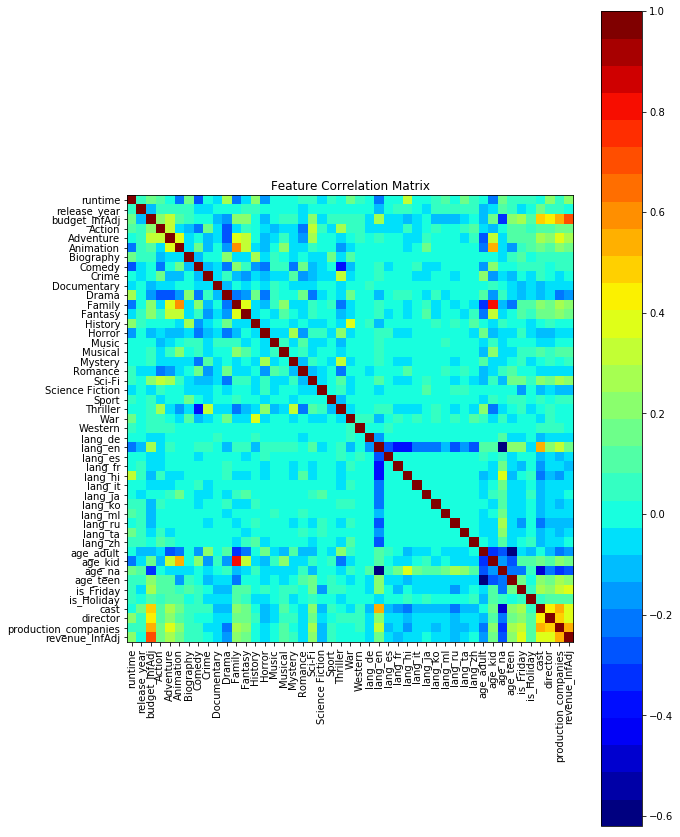

In [64]:
plt.rcParams["figure.figsize"] = (10,15)
data_visualization_and_analysis.correlation_matrix(correlation_df)

### 5.8 Split Into Train and Test Data + Randomly Shuffle Data

In [65]:
X=features
y=target

Splitting for Train 64% /  Cross Validation 20% / Test 16% :

In [66]:
X_train, X_cross, y_train, y_cross = train_test_split(X, y, test_size=0.2, random_state=100)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=100)
X_val_copy = X_val.copy()
print("Train percentage: {0:.2f}%".format(X_train.shape[0]/X.shape[0]*100))
print("Test percentage: {0:.2f}%".format(X_val.shape[0]/X.shape[0]*100))
print("Cross validation percentage: {0:.2f}%".format(X_cross.shape[0]/X.shape[0]*100))

Train percentage: 63.98%
Test percentage: 16.01%
Cross validation percentage: 20.02%


### 5.9 Outiler Detection on Training Data

Remove outliers where the revenue is more than 10^4 times greater than the budget.<br>
We only remove these outliers from the <b>train</b> set, but we still evaluate on movies that have this feature.

In [67]:
valid_data=abs(X_train.budget_InfAdj-y_train)<4

X_train=X_train[valid_data]
y_train=y_train[valid_data]

## 6 Model Training and Parameter Tuning

### 6.1 Building The Model

In this sections we run many models, and print their results on the cross validation set.<br>
For many scikit-learn models, we use the GridSearchCV function in order to fine tune the parameters for an optimal model. <br>
For some of the other models, we manually iterate through parameters, evaluating them on the cross validation set in order to choose the best parameter.

#### 6.1.1 Build The Models

We initialize a dictionary to hold all cross validation results, and another to hold all models in order to create the final model.

In [68]:
performance_results = {}
trainers = {}

##### 6.1.1.1 Naive Classifier

The naive classifier guesses that all movies 'break-even' and make exactly as much as their budget.

In [69]:
reg_predict = list(X_cross['budget_InfAdj'])

mse=metrics.mean_squared_error(y_cross,reg_predict)
print("Cross Validation RMSE result {}".format(mse**0.5))

performance_results["Naive_Classifier_RMSE"] = mse**0.5

Cross Validation RMSE result 0.8882270436704641


##### 6.1.1.2 Linear Regression

In [70]:
reg = LinearRegression().fit(X_train, y_train)
reg_score=reg.score(X_cross, y_cross)
print("The Cross Validation R^2 coeffienct {}".format(reg_score))
regression_predict = reg.predict(X_cross)
trainers['Linear_Regression_Predictor']=reg
mse=metrics.mean_squared_error(y_cross,regression_predict)
print("Cross Validation RMSE result {}".format(mse**0.5))

performance_results["Linear_Regression_R^2"]  = reg_score
performance_results["Linear_Regression_RMSE"] = mse**0.5

The Cross Validation R^2 coeffienct 0.5127290559994104
Cross Validation RMSE result 0.769641709665202


In linear regression, the coefficient of the budget is 0.8044158860254024


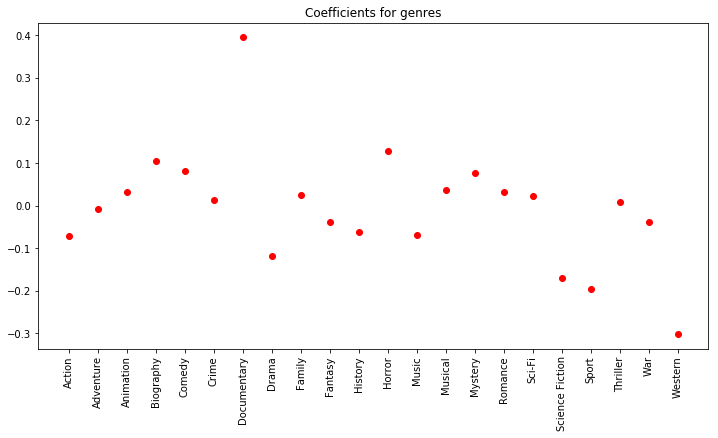

In [71]:
print("In linear regression, the coefficient of the budget is {}".format(reg.coef_[X_train.columns.get_loc("budget_InfAdj")]))

geners=list(oh_genres)
geners_coef = []
for gener in geners:
  geners_coef.append(reg.coef_[X_train.columns.get_loc(gener)])
plt.figure(figsize=(12,6))
plt.plot(geners, geners_coef, "ro")
plt.xticks(rotation=90)
plt.title("Coefficients for genres")
plt.show()

###### 6.1.1.2.1  Linear Regression with Budget Only

We try to use linear regression using only the budget, and we see that there is only a small deviation from the naive classifier.

In [72]:
reg = LinearRegression().fit(X_train[['budget_InfAdj']], y_train)
reg_score=reg.score(X_cross[['budget_InfAdj']], y_cross)
print("The Cross Validation R^2 coeffienct {}".format(reg_score))
reg_predict = reg.predict(X_cross[['budget_InfAdj']])

mse=metrics.mean_squared_error(y_cross,reg_predict)
print("Cross Validation RMSE result {}".format(mse**0.5))

performance_results["Linear_Regression_Budget_Only_R^2"]  = reg_score
performance_results["Linear_Regression_Budget_Only_RMSE"] = mse**0.5

print("Budget coefficient: {}".format(reg.coef_[0]))

The Cross Validation R^2 coeffienct 0.368255815355242
Cross Validation RMSE result 0.8763426822197341
Budget coefficient: 1.0059146735127364


##### 6.1.1.3 Random Forest Regressor

In [73]:
max_depth=[2,5,10,15]
n_estimators=[800,1000]
param_grid={"max_depth":max_depth,"n_estimators":n_estimators}

reg=GridSearchCV(RandomForestRegressor(random_state=0), param_grid=param_grid,n_jobs=-1,cv=3)

reg.fit(X_train,y_train)
trainers['RF_Regression_Predictor']=reg
rfg_predict = reg.predict(X_cross)
reg_score=reg.score(X_cross, y_cross)
mse=metrics.mean_squared_error(y_cross,rfg_predict)
print("Cross Validation RMSE result {}".format(mse**0.5))
print("Cross Validation REGR R^2 result {}".format(reg_score))
best_max_depth=reg.best_params_['max_depth']
print("The best max depth :"+str(best_max_depth))

best_n_estimators=reg.best_params_['n_estimators']
print("The best number of estimators :"+str(best_n_estimators))
performance_results["Random Forest Regressor_d{}_n{}_R^2".format(best_max_depth,best_n_estimators)]  = reg_score
performance_results["Random Forest Regressor_d{}_n{}_RMSE".format(best_max_depth,best_n_estimators)] = mse**0.5


Cross Validation RMSE result 0.8200688094768817
Cross Validation REGR R^2 result 0.44678504438433064
The best max depth :10
The best number of estimators :800


##### 6.1.1.4 SVR

In [74]:
kernel=['linear','poly', 'rbf']
C=[0.001,0.01,5,10,20]
gamma=[0.5e-1,1e-2,1.5e-2]
param_grid={"kernel":kernel,"C":C,"gamma":gamma}

reg=GridSearchCV(SVR(max_iter=10000), param_grid=param_grid,n_jobs=-1,cv=3)

reg.fit(X_train,y_train)
trainers['SVR_Regression_Predictor']=reg
svr_predict = reg.predict(X_cross)
reg_score=reg.score(X_cross, y_cross)
mse=metrics.mean_squared_error(y_cross,svr_predict)
print("Cross Validation RMSE result {}".format(mse**0.5))
print("Cross Validation REGR R^2 result {}".format(reg_score))
best_kernel=reg.best_params_['kernel']
best_C=reg.best_params_['C']
best_gamma=reg.best_params_["gamma"]
print("The best kernel: {}".format(best_kernel))
print("The best C parameter: {}".format(best_C))
print("The best gamma parameter: {}".format(best_gamma))
performance_results["SVR_kernel_{}_C{}_R^2".format(best_kernel, best_C)]  =reg_score
performance_results["SVR_kernel_{}_C{}_RMSE".format(best_kernel, best_C)] = mse**0.5

Cross Validation RMSE result 0.7687775083981048
Cross Validation REGR R^2 result 0.5138227174870771
The best kernel: rbf
The best C parameter: 5
The best gamma parameter: 0.01


##### 6.1.1.5 ElasticNet

In [75]:
reg = ElasticNet(alpha=0.004).fit(X_train, y_train)
reg_score=reg.score(X_cross, y_cross)
print("The Cross Validation R^2 coeffienct {}".format(reg_score))
reg_predict = reg.predict(X_cross)
trainers['EN_Regression_Predictor']=reg
mse=metrics.mean_squared_error(y_cross,reg_predict)
print("Cross Validation RMSE result {}".format(mse**0.5))

performance_results["ElasticNet_R^2"]  = reg_score
performance_results["ElasticNet_RMSE"] = mse**0.5

The Cross Validation R^2 coeffienct 0.5091153483845979
Cross Validation RMSE result 0.7724903532856066


##### 6.1.1.6 KNN Regressors

In [76]:
n_neighbors=list(range(3,13,1))

param_grid={"n_neighbors":n_neighbors}

reg=GridSearchCV(KNeighborsRegressor(), param_grid=param_grid,n_jobs=-1,cv=3)

reg.fit(X_train,y_train)
trainers['KNN_Regression_Predictor']=reg
knn_predict = reg.predict(X_cross)
mse=metrics.mean_squared_error(y_cross,knn_predict)
reg_score=reg.score(X_cross, y_cross)
print("Cross Validation RMSE result: {}".format(mse**0.5))
print("Cross Validation REGR R^2 result: {}".format(reg_score))
performance_results["KNN_{}_neighbors_R^2".format(reg.best_params_['n_neighbors'])]  = reg_score
performance_results["KNN_{}_neighbors_RMSE".format(reg.best_params_['n_neighbors'])] = mse**0.5

Cross Validation RMSE result: 0.8022167215884798
Cross Validation REGR R^2 result: 0.4706087676051952


##### 6.1.1.7 MLP Regressor


In [77]:
activation=["logistic", "tanh", "relu"]
solver=["adam"]
learning_rate=["constant","invscaling","adaptive"]
param_grid={"activation":activation,"learning_rate":learning_rate,"solver":solver}
model= GridSearchCV(neural_network.MLPRegressor(hidden_layer_sizes=(13,),alpha=0.25,shuffle=True), param_grid=param_grid,n_jobs=-1,cv=3)
reg =model.fit(X_train, y_train)
trainers['MLP_Regression_Predictor']=reg
reg_score=reg.score(X_cross, y_cross)
print("The Cross Validation R^2 coeffienct {}".format(reg_score))
mlp_predict = reg.predict(X_cross)

mse=metrics.mean_squared_error(y_cross,mlp_predict)
print("Cross Validation RMSE result {}".format(mse**0.5))

performance_results["MPL_R^2"]  = reg_score
performance_results["MPL_RMSE"] = mse**0.5

The Cross Validation R^2 coeffienct 0.5205362445068664
Cross Validation RMSE result 0.7634511075330461


##### 6.1.1.8 Kernel Ridge

In [78]:
kernel=['linear','poly', 'rbf']
gamma=[1,1e-2,1e-2,1e-4,1e-5]
degree=[2,3,4,5]
param_grid={"kernel":kernel,"gamma":gamma,"degree":degree}

reg = KernelRidge()
reg.fit(X_train, y_train)
trainers['Ridge_Regression_Predictor']=reg
reg_score=reg.score(X_cross, y_cross)
print("The Cross Validation R^2 coeffienct {}".format(reg_score))
kernel_predict = reg.predict(X_cross)
mse=metrics.mean_squared_error(y_cross,kernel_predict)
print("Cross Validation RMSE result {}".format(mse**0.5))
performance_results["KernelRidge_R^2"]  = reg_score
performance_results["KernelRidge_RMSE"] = mse**0.5

The Cross Validation R^2 coeffienct 0.5078848829866945
Cross Validation RMSE result 0.7734579204527765


##### 6.1.1.9 CatBoost

In [79]:
min_mse=10
iters=[i for i in range(30,70,10)]
lrs=[i/100 for i in range(20,40,5)]
deps=[i for i in range(3,6) ]
for ite in iters:
  for lr in lrs:
    for dep in deps:
      model = CatBoostRegressor(iterations=ite, learning_rate=lr, depth=dep,silent=True)
      model.fit(X_train, y_train)
      preds = model.predict(X_cross)
      mse=metrics.mean_squared_error(y_cross,preds)
      if(min_mse>mse**0.5):
        min_mse=mse**0.5
        trainers['CatBoost']=model
print("Cross Validation RMSE result {}".format(min_mse))

Cross Validation RMSE result 0.755322404280586


##### 6.1.1.10 XgBoost

In [80]:
min_mse=10
est=50
lr=0.15
dep=2
iters=[i for i in range(10,60,10)]
lrs=[i/100 for i in range(10,31,5)]
deps=[i for i in range(2,5) ]
for est in iters:
  for lr in lrs:
    for dep in deps:
      xgb = xgboost.XGBRegressor(n_estimators=est, learning_rate=lr, gamma=0, subsample=0.75,colsample_bytree=1, max_depth=dep)
      xgb.fit(X_train,y_train)
      preds = xgb.predict(X_cross)
      mse=metrics.mean_squared_error(y_cross,preds)
      if(min_mse>mse**0.5):
        min_mse=mse**0.5    
        trainers['XGBoost']=xgb
print("Cross Validation RMSE result {}".format(min_mse))

Cross Validation RMSE result 0.7657616973401837


##### 6.1.1.11 LightGBM

In [81]:
min_mse=10

iters=[i for i in range(30,60,10)]
lrs=[i/100 for i in range(1,25,5)]
deps=[i for i in range(20,60,10) ]
for est in iters:
  for lr in lrs:
    for dep in deps:
      lgb = lightgbm.LGBMRegressor(num_leaves=est, learning_rate=lr, n_estimators=dep)
      lgb.fit(X_train, y_train)
      preds = lgb.predict(X_cross)
      mse=metrics.mean_squared_error(y_cross,preds)
      if(min_mse>mse**0.5):
        min_mse=mse**0.5   
        trainers['LightGBM']=lgb
print("Cross Validation RMSE result {}".format(min_mse))

Cross Validation RMSE result 0.790445719574629


### 6.2 Parameter tuning - Creating a weighted model

We use the <b>cross validation</b> results and the ElasticNet model in order to calculate weights for the each of our models. <br> We use these weights, normalizing them to a PDF, to create a weighted average on the models.

In [82]:
test_pred=pd.DataFrame()
for key in trainers:
  y=trainers[key].predict(X_cross)
  test_pred[key]=y

reg = linear_model.ElasticNet(alpha=1).fit(test_pred, y_cross)
coef_list=list(reg.coef_)
sum_coef=sum(list(reg.coef_))

normalized_coefs=[x/sum_coef for x in coef_list]

## 7 Model Evaluation

### 7.1 Evaluating final model on test

After calculating the normalized coefficents for each of the models, we create a final model where the prediction is the weighted average based on these coefficients. <br>Our model is run on the <b>test</b> data to achieve our final results:

In [83]:
final_pred=pd.DataFrame()
print("Coeffiecents for each of the models:\n")
for key,coef in zip(trainers,normalized_coefs):
  print(key,coef)
  y=trainers[key].predict(X_val)
  final_pred[key]=coef*y

weighted_sum=final_pred.sum(axis=1)

print()
reg_score=metrics.r2_score(y_val,weighted_sum)
mse=metrics.mean_squared_error(y_val,weighted_sum)
print("The R^2 coeffienct {}".format(reg_score))
print("RMSE result {}".format(mse**0.5))

Coeffiecents for each of the models:

Linear_Regression_Predictor 0.14860289059615597
RF_Regression_Predictor 0.10209855040698115
SVR_Regression_Predictor 0.0
EN_Regression_Predictor 0.06350801857579516
KNN_Regression_Predictor 0.0
MLP_Regression_Predictor 0.12685128971582568
Ridge_Regression_Predictor 0.18335820889042295
CatBoost 0.0
XGBoost 0.3755810418148191
LightGBM 0.0

The R^2 coeffienct 0.6893171938050073
RMSE result 0.5939571149834152


### 7.2 Model Performance Graph

We return the budget and revenue to their original values (undoing the logarthmic scaling), and display our model results on the test data.

Results graph sorted by revenue of the test data
(the red curve describes our prediction, the blue dots the budget, and the black dots the actual revenue)


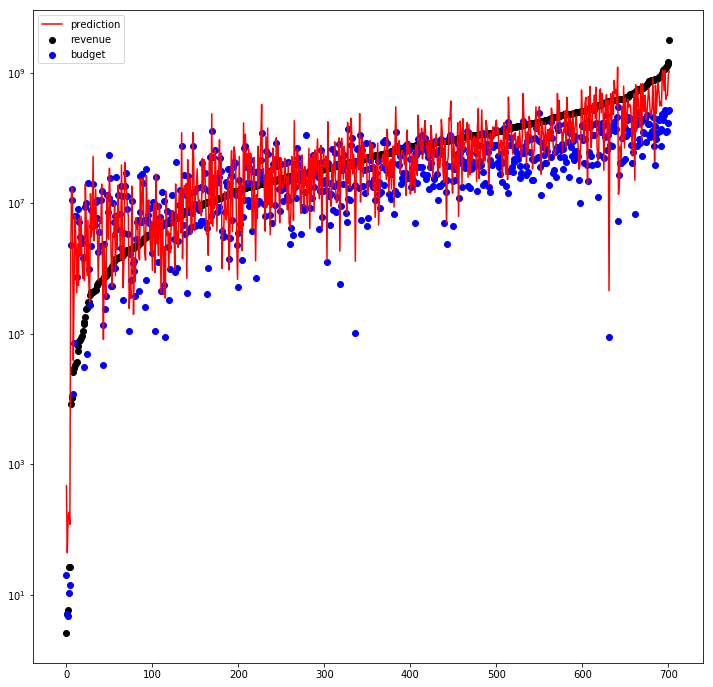

In [84]:
y_val_scaled=10**y_val.reset_index(drop=True).copy()
budget_scaled=10**X_val.budget_InfAdj.reset_index(drop=True).copy()
average_scaled=10**weighted_sum.copy()

index=np.argsort(y_val_scaled)

plt.figure(figsize=(12,12))
plt.scatter(np.arange(len(y_val_scaled[index])), y_val_scaled[index], c='k', label='revenue')
plt.scatter(np.arange(len(budget_scaled[index])), budget_scaled[index], c='b', label='budget')
plt.plot(np.arange(len(average_scaled[index])), average_scaled[index], c='r',label='prediction')
plt.legend()
plt.yscale("log")

print("Results graph sorted by revenue of the test data")
print("(the red curve describes our prediction, the blue dots the budget, and the black dots the actual revenue)")
plt.show()